In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
import gmsh
import meshio
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
import scipy.interpolate
import scipy.sparse

from femns2d import femns2d

In [4]:
%load_ext autoreload
%autoreload 2

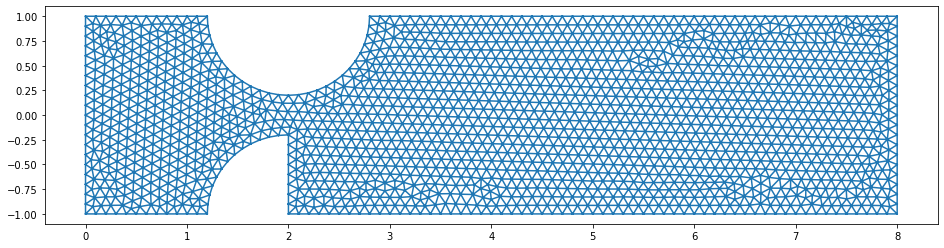

In [6]:
mesh = meshio.read("tube.msh")
mesh.cell_sets['gmsh:bounding_entities'] = mesh.cell_sets['gmsh:bounding_entities'][-1:]
# Plot the mesh
fig, ax = plt.subplots(figsize=(16, 4))
ax.triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells_dict["triangle"])

plt.savefig("results_ns/mesh_figure.png")
plt.show()


In [7]:
def is_inside(triangles, points, strictly=True):
    # Expand dimensions of points to match the triangles' shape
    points_shape = (1,) * (triangles.ndim - 3) + points.shape
    points_expanded = points.reshape(points_shape)
    
    # Compute vectors
    v0 = triangles[..., 2, :] - triangles[..., 0, :]
    v1 = triangles[..., 1, :] - triangles[..., 0, :]
    v2 = points_expanded[..., np.newaxis, :] - triangles[..., 0, :]
    
    # Compute dot products
    d00 = np.sum(v0 * v0, axis=-1, keepdims=True)
    d01 = np.sum(v0 * v1, axis=-1, keepdims=True)
    d11 = np.sum(v1 * v1, axis=-1, keepdims=True)
    d20 = np.sum(v2 * v0, axis=-1, keepdims=True)
    d21 = np.sum(v2 * v1, axis=-1, keepdims=True)
    
    # Compute denominator
    denom = d00 * d11 - d01 * d01
    
    # Compute barycentric coordinates
    lambda1 = (d11 * d20 - d01 * d21) / denom
    lambda2 = (d00 * d21 - d01 * d20) / denom
    lambda3 = 1 - lambda1 - lambda2
    
    # Check if all barycentric coordinates are within the range (0, 1)
    if strictly:
        inside = (lambda1 > 0) & (lambda2 > 0) & (lambda3 > 0)
    else:
        inside = (lambda1 >= 0) & (lambda2 >= 0) & (lambda3 >= 0)
    
    # Reduce to the expected shape
    inside = np.squeeze(inside, -1)
#     inside = np.squeeze(inside, axis=(-1, -2))
    
    return inside

#np.all(is_inside(element_points, x) == np.eye(x.shape[0], dtype=bool))
#x = assembler.centroids[..., :-1]
#element_points = mesh.points[mesh.cells_dict['triangle'], :-1]
#np.all(is_inside(element_points, x) == np.eye(x.shape[0], dtype=bool))

In [31]:
Re = 30.0
steps = 20
velocity_cap = 100
Re_init = 0.1
Re_schedule = np.linspace(0.1, Re, steps)
assembler = femns2d.MiniAssembler(mesh)


In [32]:
with np.load(f"results_ns/results_choked_{Re}.npz") as data:
    uxyp = data['uxyp']
    uxyp_stokes = data['uxyp_stokes']

In [33]:
ux, uy, p = assembler.split_velocities(uxyp)
uxn, uyn = ux[:assembler.npoints], uy[:assembler.npoints]

ux_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], ux)
uy_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], uy)
p_interp = scipy.interpolate.LinearNDInterpolator(assembler.points[:, :-1], p)

X, Y = np.meshgrid(np.linspace(0, 8, 51), np.linspace(-1, 1, 51))
M = assembler.is_inside_domain(np.stack([X, Y], axis=-1), tol=1e-1)
UX = ux_interp(X, Y)
UY = uy_interp(X, Y)
P = p_interp(X, Y)

x, y = assembler.pointse[:, 0], assembler.pointse[:, 1]
ux_s, uy_s, p_s = assembler.split_velocities(uxyp_stokes)
uxn_s, uyn_s = ux_s[:assembler.npoints], uy_s[:assembler.npoints]

dux, duy, dp = ux - ux_s, uy-uy_s, p - p_s


In [34]:
strain_tensor = np.stack([assembler.get_linear_element_equation(uxn)[..., :-1],
                          assembler.get_linear_element_equation(uyn)[..., :-1]], axis=-1)
strain_tensor = (strain_tensor + strain_tensor.swapaxes(-2, -1))/2

In [35]:
second_invariant = (strain_tensor**2).sum(axis=-1).sum(axis=-1)

In [36]:
un = np.stack([uxn, uyn], axis=-1)
uns = np.stack([uxn_s, uyn_s], axis=-1)
second_invariant = (strain_tensor**2).sum(axis=-1).sum(axis=-1)

In [37]:
point_data = {"ux":uxn, "uy":uyn, "p":p, "ux_s":uxn_s, "uy_s":uyn_s, "p_s": p_s, "u":un, "us":uns,
              "dux":uxn - uxn_s, "duy":uyn-uyn_s, "du":un - uns}
mesh_for_write = meshio.Mesh(
    mesh.points[..., :-1],
    cells = [("triangle", mesh.cells_dict['triangle'])],
    point_data=point_data,
)


In [38]:
mesh_for_write.write(f"results_ns/results_choked_{Re}.vtu",
                     file_format="vtu")

Warning: VTU requires 3D points, but 2D points given. Appending 0 third component.

In [39]:
np.savez("results_choked.npz", uxyp=uxyp, uxyp_stokes=uxyp_stokes)